In [1]:
import scipy as sp
from scipy import optimize
import numpy as np
from numpy import array
from scipy import linalg
import matplotlib.pyplot as plt
from pandas import DataFrame,Series
from dateutil.parser import parse
import pymongo, jieba, datetime, re, json
import pandas as pd 
from datetime import timedelta


# tau=0.045
def fourier_func(x,*a):
    ret = a[0]
    w=a[1]
    start = 2
    if len(a) % 2 ==1:
        start = 1
    for deg in range(start,len(a),2):
        ret+=a[deg]*np.cos(deg*w*x)+a[deg+1]*np.sin(deg*w*x)
    return ret

def analyze(content,key):
    m={}
    for i in content:
        d = parse(i['datetime'])
        c = i['content']
#         m[d] = m.get(d,0)+len(re.findall(string=c,pattern=key))
        have = 0
        if len(re.findall(string=c,pattern=key)) > 0: 
            have = 1
        m[d] = m.get(d,0)+have
    return Series(m)

def change_index(s1,s3,start=0,end=-1):
    '''
    s1:原始数据
    s3:拟合曲线
    start:s3拟合原始数据的开始
    end:s3拟合原始数据的结束
    '''
    start_date = s1.index[start]
    end_date = s1.index[end]
    length = len(s3.index)
    
    curve_date = pd.date_range(start=start_date,end=pd.date_range(end_date,periods=4,freq='Q-JAN')[-1],periods=length)
    s3.index = curve_date
    
def curve(key_word='无',n=10,start=0,end=-1,freq='Q-JAN',curve_func=fourier_func,predict=True,
          col=pymongo.MongoClient('localhost')['scrapy']['predict'],
         src_col = pymongo.MongoClient('localhost')['scrapy']['HypebeastItem']):
    '''
    给出数据，进行拟合，并进行显示和保存
    key_word:拟合关键词
    n:傅里叶级数的阶数
    start:拟合数据的开始
    end:拟合数据的阶数
    freq:周期
    curve_func:用于拟合的函数
    predict:是否显示预测线
    col:用于保存的MongoDB
    src_col:原始数据
    '''
    cursor = src_col.find()
    out = analyze(cursor,key_word)
    sm = out.resample(freq).sum()
    smr = Series(data = sm.data,index=[x for x in range(0,len(sm.index))])
    x_data = smr.index[start:end]
    y_data = smr.data[start:end]
    func = fourier_func
    params, params_convariance = optimize.curve_fit(func, x_data, y_data,[1.0]*n)
    print(params)
    plt.plot(x_data,y_data,marker='o',color='g',
            label='data')


    plt.plot(x_data,func(x_data,*params),color='red',
            label='fit_curved')

    x_temp = np.linspace(x_data[0],x_data[-1]+4,100)

    if predict:
        plt.plot(x_temp,func(x_temp,*params),'b--',label='real_fit_curved')


    plt.title(key_word)
    plt.legend()
    plt.show()
    #     保存数据
    s3= Series(func(x_temp,*params),x_temp)
    
    change_index(sm,s3,start,end)
    
    
    df1 = DataFrame({'data':sm})
    df2 = DataFrame({'curve':s3})
    
    df3 = df1.add(df2,fill_value=0)
    
    df3.plot()
    
    j = json.loads(df3.to_json(orient='split',date_unit='s'))

    j['key'] = key_word
    j['freq'] = freq
    
#     col.insert_one(j)
    col.update_one({"key":j['key'],"freq":j['freq']},{"$set":j},upsert=True)
    



In [2]:
def decompose_num(nums):
    '''
    切割数字
    如：nums=['2015', '07', '31']
    返回[2, 0, 1, 5, 0, 7, 3, 1]
    '''
    a=[]
    for num in nums:
        for j in num:
            a.append(int(j))
    return a
decompose_num(['2015', '07', '31'])

[2, 0, 1, 5, 0, 7, 3, 1]

8
After 0 training step(s), MSE on all data is 493.772
After 1000 training step(s), MSE on all data is 55.5685
After 2000 training step(s), MSE on all data is 35.9482
After 3000 training step(s), MSE on all data is 24.9964
After 4000 training step(s), MSE on all data is 18.2518
After 5000 training step(s), MSE on all data is 14.383
After 6000 training step(s), MSE on all data is 11.8574
After 7000 training step(s), MSE on all data is 10.2954
After 8000 training step(s), MSE on all data is 9.44944
After 9000 training step(s), MSE on all data is 8.84895
After 10000 training step(s), MSE on all data is 8.43629
In the test data, the model MSE is 80.3984


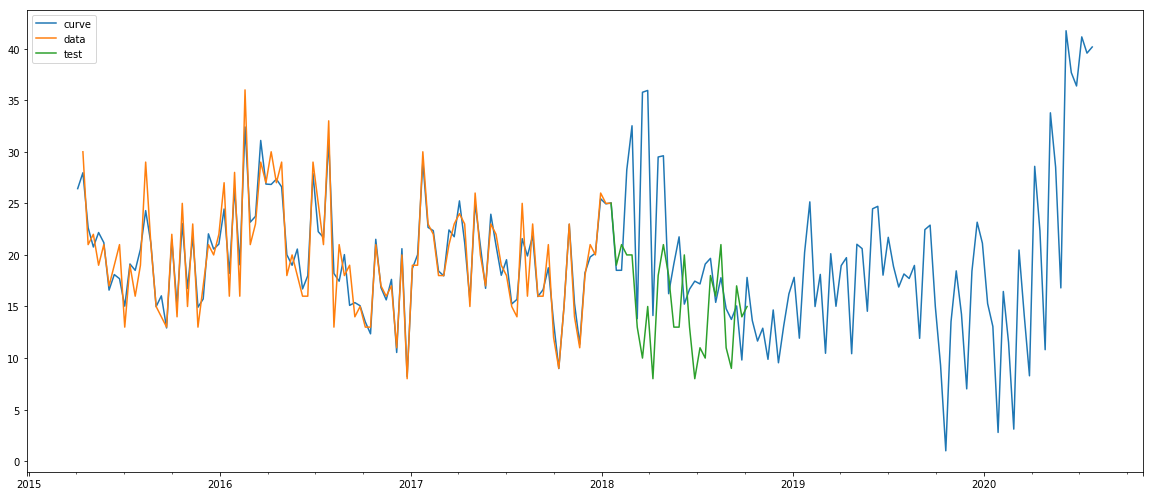

In [26]:
import tensorflow as tf
import random

# 正则化损失函数系数
REGULARIZATION_RATE = 0.05
# 隐藏层神经元数目
HIDDEN_LAYER=50
# 输出节点数目
OUTPUT_NODE=1
FREQ='10d'
KEYWORD='红'

train_percent = 0.8



# 获取数据
col = pymongo.MongoClient('localhost')['scrapy']['HypebeastItem']
cursor = col.find()
s = analyze(cursor,KEYWORD)
s = s.resample(FREQ).sum()
# 去掉第一个和最后一个数据
ss = s[1:-1]

train_size = int(train_percent*len(ss))
test_size = len(ss)-train_size
train_data = ss[:train_size]
test_data = ss[train_size-1:]
raw_data = s
test_x = [decompose_num(str(t.date()).split('-')) for t in test_data.index]
test_y = [[t] for t in test_data]

resample_data=s
resample_split_data=ss

X=[decompose_num(str(t.date()).split('-')) for t in train_data.index]
Y = [[t] for t in train_data]

input_node=len(X[0])
print(input_node)



# 清空图
tf.reset_default_graph()

# 模型 
# 权重
w1 = tf.Variable(tf.random_normal([input_node,HIDDEN_LAYER]))
w2 = tf.Variable(tf.random_normal([HIDDEN_LAYER,HIDDEN_LAYER]))
w3 = tf.Variable(tf.random_normal([HIDDEN_LAYER,OUTPUT_NODE]))
# 偏置值
biases1 = tf.Variable(tf.constant(0.1,shape=[HIDDEN_LAYER]))
biases2 = tf.Variable(tf.constant(0.1,shape=[HIDDEN_LAYER]))
biases3 = tf.Variable(tf.constant(0.1,shape=[OUTPUT_NODE]))
# 输入输出占位符
x = tf.placeholder(tf.float32,shape=(None,input_node),name='x-input')
y_ = tf.placeholder(tf.float32,shape=(None,1),name='y-input')
# 计算设置
a1 = tf.nn.sigmoid(tf.matmul(x,w1) + biases1)
a2 = tf.nn.sigmoid(tf.matmul(a1,w2) + biases2)
y = tf.nn.relu(tf.matmul(a2,w3) + biases3)

# a = tf.matmul(x,w1) + biases1
# y = tf.matmul(a,w2) + biases2

# 计算L2正则化损失函数
regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
# 计算模型正则化损失。一般只计算权重，而不用偏置值
regularization = regularizer(w1)+regularizer(w2)

# 定义mse
mse = tf.reduce_mean(tf.square(y_ - y))

# 定义损失函数
# y_为标准答案
# loss = mse
loss = mse + regularization
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)


# 模型训练结果
model_x = [decompose_num(str(x.date()).split('-')) for x in pd.date_range(raw_data.index[0],periods=int(len(raw_data)*1.5),freq=FREQ)]
model_y = None

# 声明tf.train.Saver用于保存模型
saver = tf.train.Saver()

with tf.Session() as sess:
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    STEPS = 10001
    for i in range(STEPS):
        if i % 1000 == 0:
            print("After %d training step(s), MSE on all data is %g" % (i,sess.run(loss,feed_dict={x:X,y_:Y})))
        sess.run(train_step,feed_dict={x:X,y_:Y})
#   模型训练结果
    test_feed={x:model_x}
    model_y = sess.run(y,feed_dict=test_feed)
    model_y_s=Series([x[0] for x in model_y])
    out_data = model_y_s

    # 模型在测试集的表现
    print("In the test data, the model MSE is %g" % sess.run(loss,feed_dict={x:test_x,y_:test_y}))
    
    # 模型导出
#     writer = tf.summary.FileWriter('log',sess.graph)
    # 模型持久化
#     saver.save(sess,"model/{}.ckpt".format(KEYWORD))
    
    # 保存结果
    # 切换换回原来的坐标轴
    # 需要train_data,test_data,out_data
    out_data.index = pd.date_range(start=raw_data.index[0],freq=FREQ,periods=len(out_data))
    # 合并原始数据转成字典
    df_data1 = DataFrame({'curve':out_data})
    df_data2 = DataFrame({'data':train_data})
    df_data3 = DataFrame({'test':test_data})
    df_data = df_data1.add(df_data2,fill_value=0)
    df_data = df_data.add(df_data3,fill_value=0)
    df_data.plot(figsize=(20, 8.5))
#     j_data = json.loads(df_data.to_json(orient='split',date_unit='s'))
    # 添加key，freq，option
#     j_data['key'] = KEYWORD
#     j_data['freq']=FREQ
#     j_data['option']='TensorFlow'
#     print(j_data)
    # 保存到MongoDB
#     predict_col = pymongo.MongoClient('localhost')['scrapy']['predict']
#     predict_col.update_one({"key":j_data['key'],"freq":j_data['freq']},{"$set":j_data},upsert=True)
    